In [3]:
import pandas as pd
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import deque

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt

In [4]:
init_df = pd.read_csv('TSLA.csv')

In [5]:
LOOKUP_STEPS = [1, 2, 3]

N_STEPS = 7

STOCK = 'TSLA'

In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

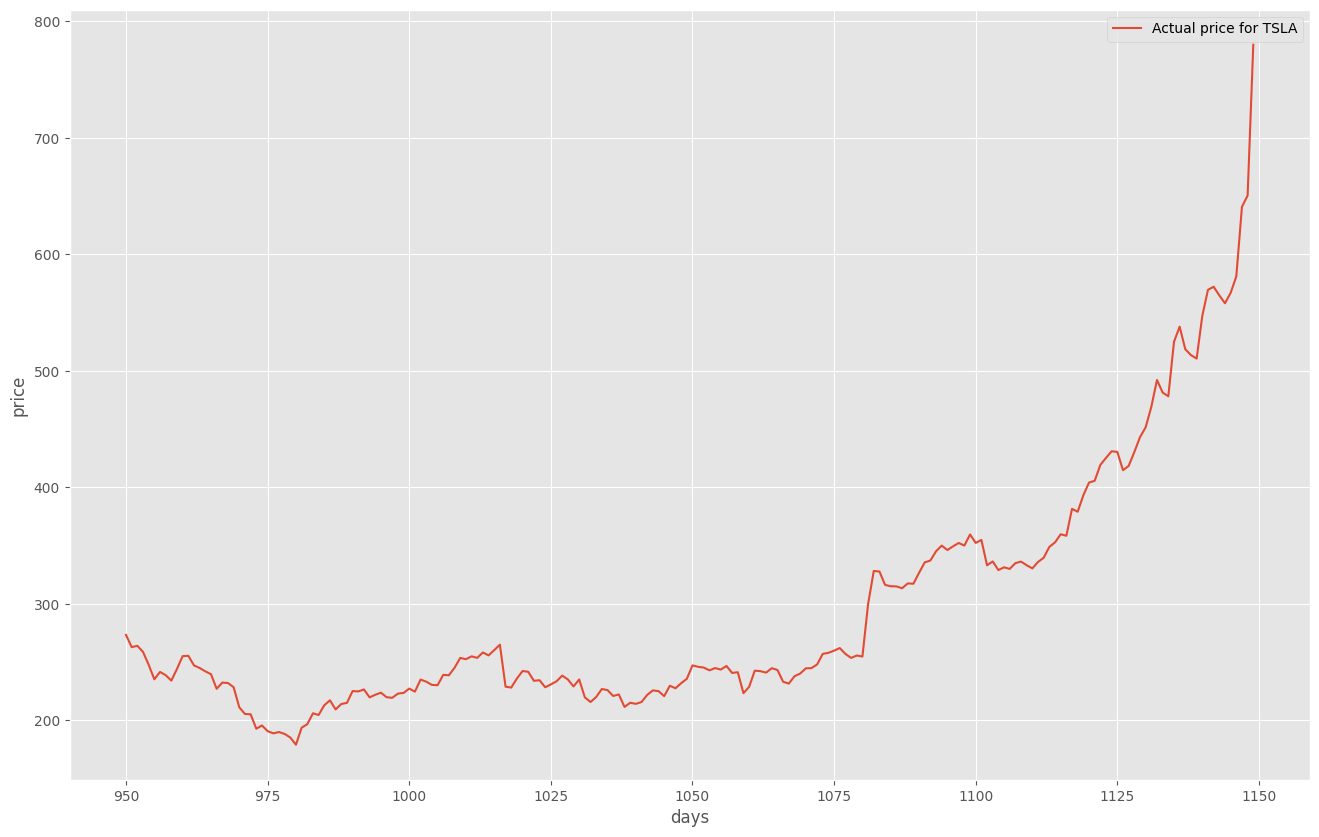

In [7]:

# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['Close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [8]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['Close'] = scaler.fit_transform(np.expand_dims(init_df['Close'].values, axis=1))

In [9]:
def PrepareData(days):
    df = init_df.copy()
    df['future'] = df['Close'].shift(-days)
    last_sequence = np.array(df[['Close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['Close'] + ['Date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['Close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

In [10]:
def GetTrainedModel(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['Close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 10
    EPOCHS = 20

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

    model.summary()

    return model

In [11]:
# GET PREDICTIONS
predictions = []
df, last_sequence, x_train, y_train = PrepareData(0)
for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = PrepareData(step)
    x_train = x_train[:, :, :len(['Close'])].astype(np.float32)

    model = GetTrainedModel(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

Epoch 1/20
115/115 [==============================] - 14s 21ms/step - loss: 0.0032
Epoch 2/20
115/115 [==============================] - 2s 22ms/step - loss: 0.0011
Epoch 3/20
115/115 [==============================] - 2s 18ms/step - loss: 0.0012
Epoch 4/20
115/115 [==============================] - 2s 18ms/step - loss: 9.7494e-04
Epoch 5/20
115/115 [==============================] - 2s 18ms/step - loss: 8.4349e-04
Epoch 6/20
115/115 [==============================] - 2s 19ms/step - loss: 7.7596e-04
Epoch 7/20
115/115 [==============================] - 2s 20ms/step - loss: 8.0120e-04
Epoch 8/20
115/115 [==============================] - 2s 20ms/step - loss: 6.8158e-04
Epoch 9/20
115/115 [==============================] - 2s 19ms/step - loss: 6.6492e-04
Epoch 10/20
115/115 [==============================] - 2s 19ms/step - loss: 7.4665e-04
Epoch 11/20
115/115 [==============================] - 2s 19ms/step - loss: 6.7400e-04
Epoch 12/20
115/115 [==============================] - 2s 18ms/

In [13]:
print(x_train)
print(x_train.shape)
print(y_train.shape)

[[[0.18147816]
  [0.18620843]
  [0.19169298]
  ...
  [0.19331163]
  [0.20585231]
  [0.21779582]]

 [[0.18620843]
  [0.19169298]
  [0.18774852]
  ...
  [0.20585231]
  [0.21779582]
  [0.19345307]]

 [[0.19169298]
  [0.18774852]
  [0.19331163]
  ...
  [0.21779582]
  [0.19345307]
  [0.19518174]]

 ...

 [[0.5811764 ]
  [0.5764776 ]
  [0.6341521 ]
  ...
  [0.6734399 ]
  [0.66184217]
  [0.6511559 ]]

 [[0.5764776 ]
  [0.6341521 ]
  [0.6692911 ]
  ...
  [0.66184217]
  [0.6511559 ]
  [0.6651109 ]]

 [[0.6341521 ]
  [0.6692911 ]
  [0.6734399 ]
  ...
  [0.6511559 ]
  [0.6651109 ]
  [0.6872535 ]]]
(1141, 7, 1)
(1141,)
